In [2]:
import sys
sys.path.append('..')
from dataset import ModisDataset, Sentinel5Dataset
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from model import Model, snapshot, restore
import ignite.metrics
import pandas as pd
from train import train_epoch, test_epoch, test_model, fine_tune
from visualizations import make_and_plot_predictions

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

num_layers = 1
hidden_size = 16
region = "germany"
include_time = False
smooth = None

model_dir="/tmp/models/"
log_dir = "/tmp/models/"
name_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}_e={epoch}_until{enddate}"
log_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}_until{enddate}"

#model_path = os.path.join(model_dir,name_pattern.format(region=region, num_layers=num_layers, 
#                                                        hidden_size=hidden_size, epoch=epoch, enddate=enddate)) 


model = Model(input_size=1 if not include_time else 2,
              hidden_size=128,
              num_layers=3,
              output_size=1,
              device=device,
              dropout=0.5)

#restore("/tmp/models/LSTM_volcanopuyehue_l=3_h=256_e=1_until2010-01-01.pth",model)
#restore("/data2/igarss2020/models/LSTM_germany_l=1_h=128_e=2.pth",model)

from dataset import transform_data
from copy import deepcopy
inner_steps = 0

enddate = '2015-01-01'
startdate = "2005-01-01"
remove_seasonality=True

#model.load_state_dict(torch.load("/tmp/model_epoch_0.pth")["model"])
model.train()
dataset = ModisDataset(region=region,
                       fold="train",
                       znormalize=True,
                       augment=False,
                       overwrite=False,
                       include_time=include_time,
                       filter_date=(None,enddate),
                       remove_seasonality=remove_seasonality,
                       smooth=smooth)

testdataset = ModisDataset(region=region,
                       fold="test",
                       znormalize=True,
                       augment=False,
                       overwrite=False,
                       include_time=include_time,
                       filter_date=(None,None),
                       remove_seasonality=remove_seasonality,
                       znormalize_with_meanstd=(dataset.mean, dataset.std),
                       smooth=smooth)

validdataset = ModisDataset(region=region,
                            fold="validate",
                            znormalize=True,
                            augment=False,
                            include_time=include_time,
                            remove_seasonality=remove_seasonality,
                            smooth=smooth)

#dataset = Sentinel5Dataset(fold="train", seq_length=300)
#validdataset = Sentinel5Dataset(fold="validate", seq_length=300)

dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=512,
                                         shuffle=True,
                                         #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                         )
validdataloader = torch.utils.data.DataLoader(validdataset,
                                         batch_size=512,
                                         shuffle=False,
                                         #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                         )

date = testdataset.date[0].astype(np.datetime64)

mask = np.isin(date.astype(str), np.array(enddate))
end_idx = np.where(mask)[0]
assert len(end_idx) > 0


def criterion(y_pred, y_data, log_variances):
    norm = (y_pred-y_data)**2
    loss = (torch.exp(-log_variances) * norm).mean()
    regularization = log_variances.mean()
    return 0.5 * (loss + regularization)

#def criterion(y_pred, y_data, log_variances):
#    norm = (y_pred-y_data)**2
#    return norm.mean()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

../train.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
train_uptodate=2015-01-01 provided. removing all observations before 2015-01-01
5659.550762982417 2363.6155647508454
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
5659.550762982417 2363.6155647508454
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
5682.0130743410555 2311.4988039773516


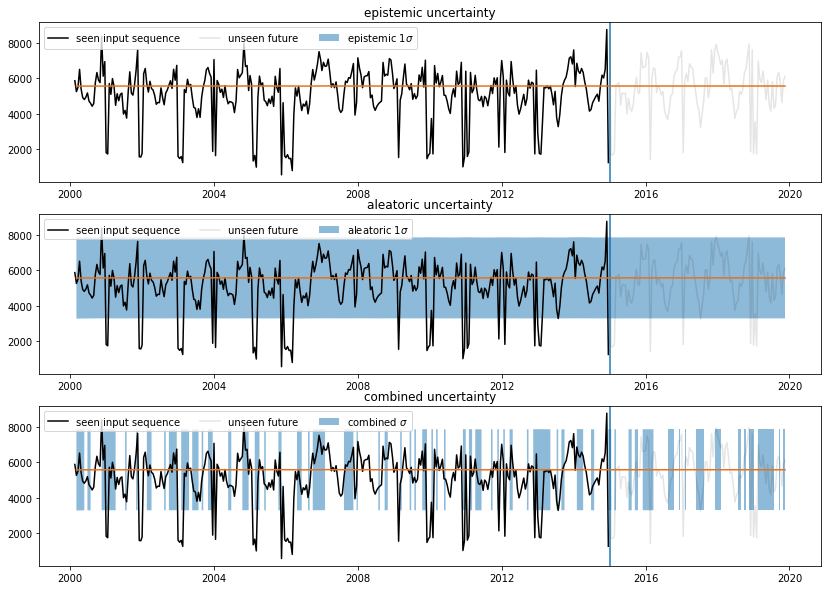

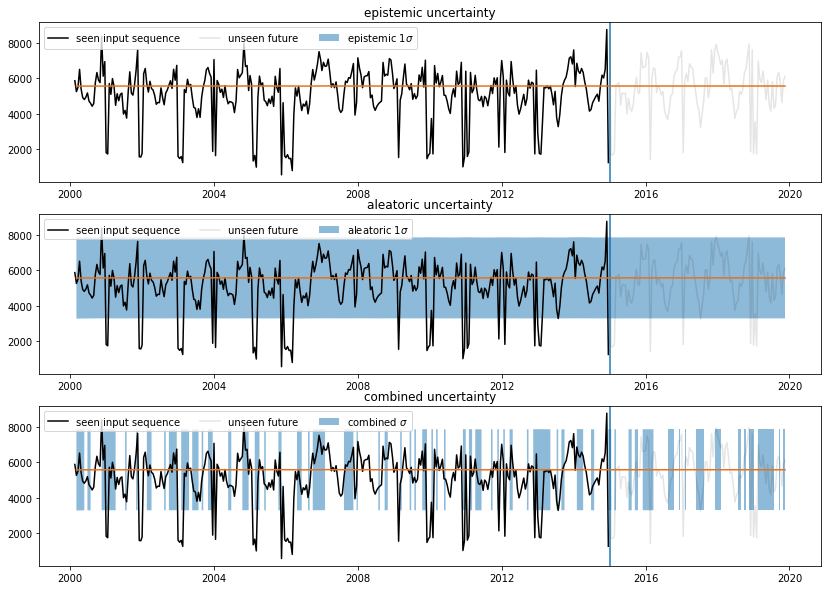

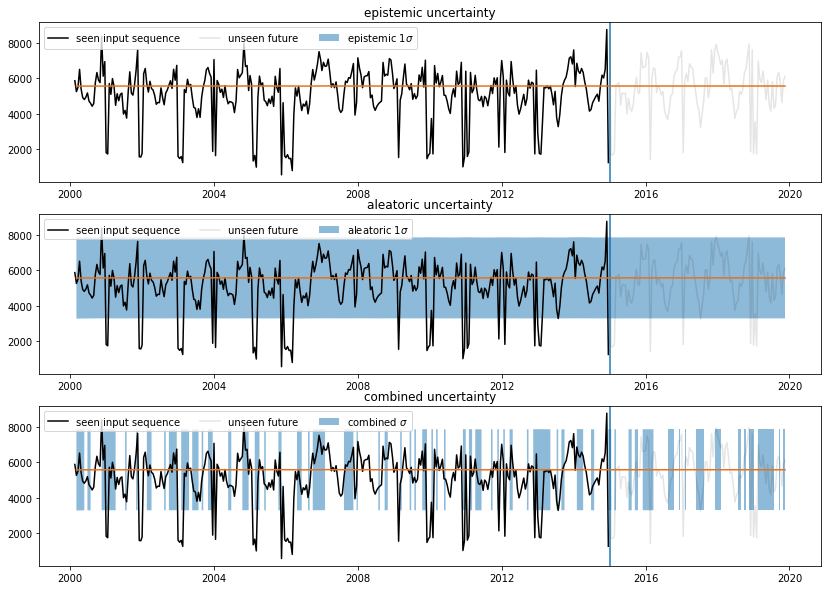

KeyboardInterrupt: 

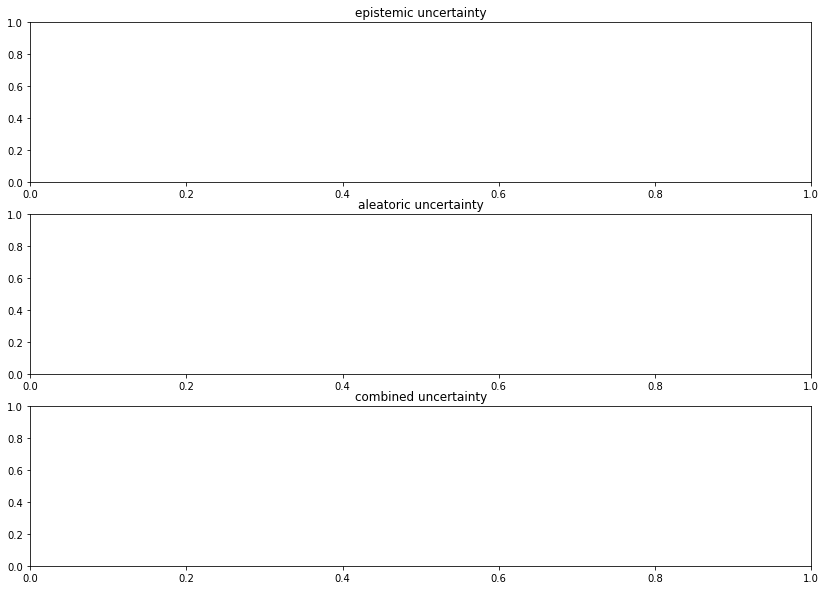

In [3]:
model_path = "/tmp/model"
stats = list()
epochs = 5
model.train()

for epoch in range(epochs):
    trainloss = train_epoch(model,dataloader,optimizer, criterion, device)
    #testmetrics, testloss = test_epoch(model,validdataloader,device, criterion, n_predictions=10)

    fig, axs = make_and_plot_predictions(model, testdataset.data[0].astype(float), date, N_seen_points=end_idx[0], N_predictions=50,
                              device=device,meanstd=(dataset.mean,dataset.std), store=None)
    plt.show()


(<Figure size 1008x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8423314e0>,
       dtype=object))

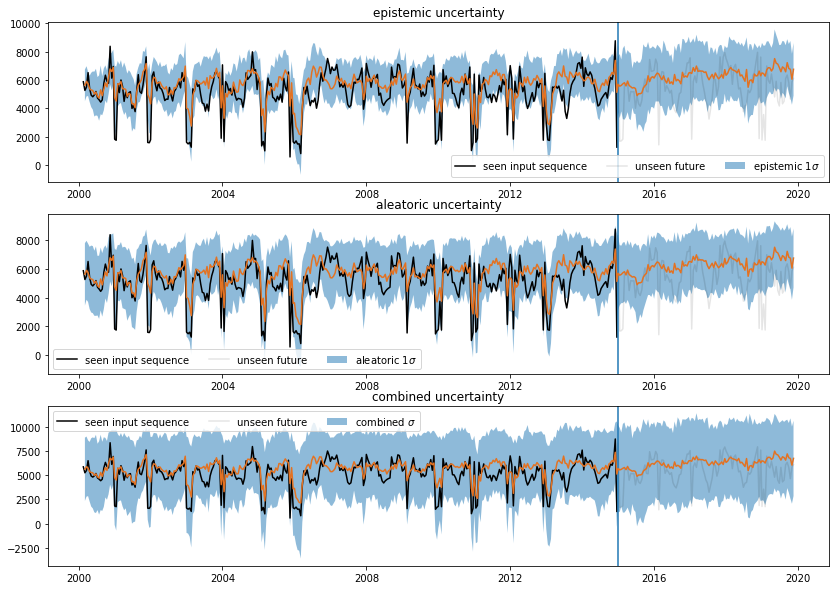

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

num_layers = 1
hidden_size = 256
region = "germany"
epochs = 100
include_time = False
smooth = None
use_attention = True

model_dir="/data2/igarss2020/models/"
log_dir = "/data2/igarss2020/models/"
name_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}_e={epoch}"
log_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}"

model = Model(input_size=1 if not include_time else 2,
              hidden_size=hidden_size,
              num_layers=num_layers,
              output_size=1,
              device=device)

#model.load_state_dict(torch.load("/tmp/model_epoch_0.pth")["model"])
model.train()

if True:
    dataset = ModisDataset(region=region,
                           fold="train",
                           znormalize=True,
                           augment=True,
                           overwrite=False,
                           include_time=include_time,
                           filter_date=(None,None),
                           smooth=smooth)

    validdataset = ModisDataset(region=region,
                                fold="validate",
                                znormalize=True,
                                augment=False,
                                include_time=include_time,
                                smooth=smooth)

else:
    dataset = Sentinel5Dataset(fold="train", seq_length=300, include_time=include_time)
    validdataset = Sentinel5Dataset(fold="validate", seq_length=300, include_time=include_time)

dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=512,
                                         shuffle=True,
                                         #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                         )
validdataloader = torch.utils.data.DataLoader(validdataset,
                                         batch_size=512,
                                         shuffle=False,
                                         #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                         )

#criterion = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')

L2Norm = torch.nn.MSELoss(reduction='none')
def criterion(y_pred, y_data, log_variances):
    norm = (y_pred-y_data)**2
    loss = (torch.exp(-log_variances) * norm).mean()
    regularization = log_variances.mean()
    return 0.5 * (loss + regularization)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

stats=list()
for epoch in range(epochs):

    trainloss = train_epoch(model,dataloader,optimizer, criterion, device)
    testmetrics, testloss = test_epoch(model,validdataloader,device, criterion, n_predictions=1)
    metric_msg = ", ".join([f"{name}={metric.compute():.2f}" for name, metric in testmetrics.items()])
    msg = f"epoch {epoch}: train loss {trainloss:.2f}, test loss {testloss:.2f}, {metric_msg}"
    print(msg)

    test_model(model, validdataset, device)

    model_name = name_pattern.format(region=region, num_layers=num_layers, hidden_size=hidden_size, epoch=epoch)
    pth = os.path.join(model_dir, model_name+".pth")
    print(f"saving model snapshot to {pth}")
    snapshot(model, optimizer, pth)

    stat = dict()
    stat["epoch"] = epoch
    for name, metric in testmetrics.items():
        stat[name]=metric.compute()

    stat["trainloss"] = trainloss.cpu().detach().numpy()
    stat["testloss"] = testloss.cpu().detach().numpy()
    stats.append(stat)

df = pd.DataFrame(stats)

local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
5773.044346451146 2303.3696837284797
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
5682.0130743410555 2311.4988039773516


TypeError: unsupported format string passed to Tensor.__format__